**Competition and data overview:**<br/>
In this competition, we are provided with the challenge of predicting total sales for every product and store in the next month. Time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

1. Exploratory analysis of the classical time-series (EDA)

In [21]:
# import packages
from tensorflow import keras
from keras.layers import LSTM,Dense,Dropout
from keras.models import Sequential, load_model, Model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
sales = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
sales.shape

(2935849, 6)

In [6]:
# parse datetime
sales.date = sales.date.apply(
    lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


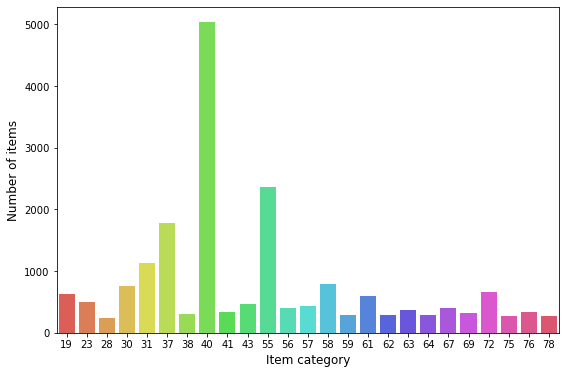

In [7]:
# how many products are in each category?
prod_per_cat = items.groupby(['item_category_id']).count()
prod_per_cat = prod_per_cat.sort_values(by='item_id', ascending=False)
prod_per_cat = prod_per_cat.iloc[0:25].reset_index()

plt.figure(figsize=(9, 6))
sns.barplot(x='item_category_id', y='item_id', data=prod_per_cat,
            palette='hls',
            capsize=0.05,
            saturation=8,
            errcolor='gray', errwidth=2,
            ci='sd')
plt.ylabel('Number of items', fontsize=12)
plt.xlabel('Item category', fontsize=12)
plt.show()

Text(0, 0.5, 'Sales')

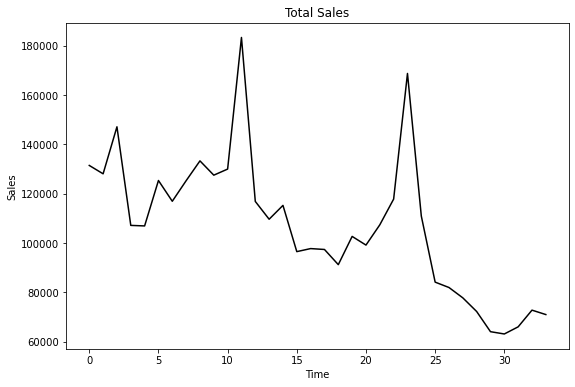

In [8]:
# total sales for one month
tot_amount = sales.groupby("date_block_num")["item_cnt_day"].sum()

plt.figure(figsize=(9, 6))
plt.plot(tot_amount, color='black')
plt.title('Total Sales')
plt.xlabel('Time')
plt.ylabel('Sales')

<AxesSubplot:xlabel='month', ylabel='item_cnt_day'>

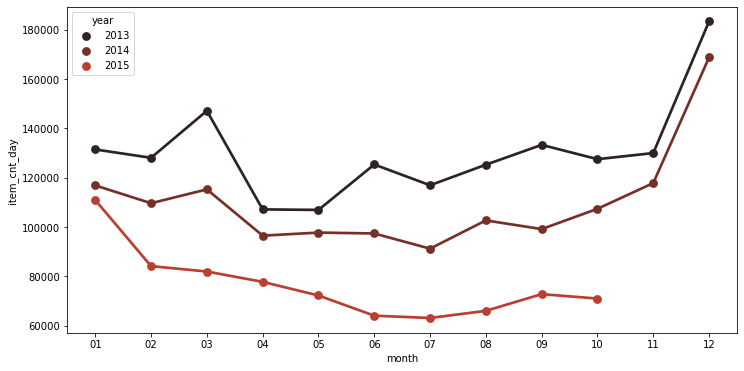

In [9]:
# calculate sales for every year
sales['year'] = sales['date'].dt.strftime('%Y')
sales['month'] = sales['date'].dt.strftime('%m')

sales_group = pd.DataFrame(sales.groupby(['year', 'month'])[
                           'item_cnt_day'].sum().reset_index())

plt.figure(figsize=(12, 6))
sns.pointplot(x='month', y='item_cnt_day', hue='year',
              data=sales_group, color="#bb3f30")

<AxesSubplot:xlabel='month', ylabel='item_price'>

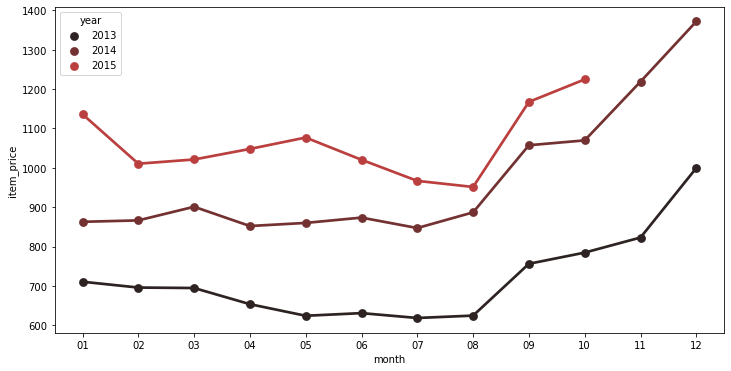

In [10]:
# price behaviour for every year
price_group = pd.DataFrame(sales.groupby(['year', 'month'])[
                           'item_price'].mean().reset_index())

plt.figure(figsize=(12, 6))
sns.pointplot(x='month', y='item_price', hue='year',
              data=price_group, color="#bb3f3f")

2. Data Cleaning and Preparation

In [11]:
# items both in test and train sets
sales = sales[sales['item_id'].isin(test['item_id'].unique())]
# shops both in test and train sets
sales = sales[sales['shop_id'].isin(test['shop_id'].unique())]

In [12]:
sales.shape

(1224439, 8)

3. checking for outliers

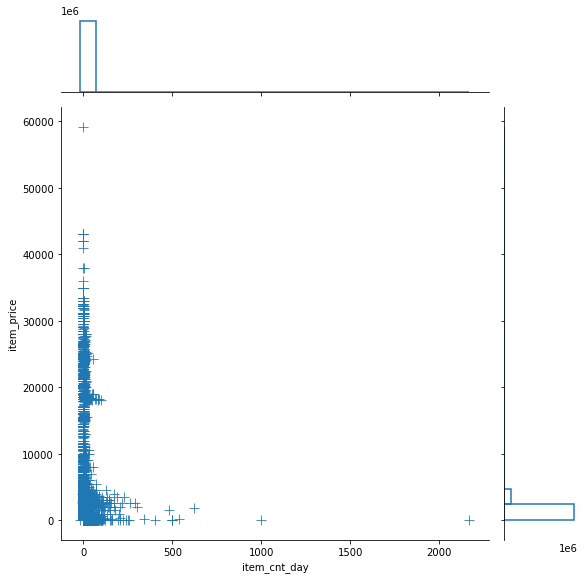

In [13]:
sns.jointplot(x="item_cnt_day", y="item_price", data=sales, height=8, 
              marker="+", s=100, marginal_kws=dict(bins=25, fill=False))

In [14]:
sales.item_cnt_day.describe()

count    1.224439e+06
mean     1.321234e+00
std      3.312997e+00
min     -1.600000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [15]:
# correct values
sales = sales.query('item_price > 0')
sales = sales.query('item_cnt_day >= 0 and item_cnt_day <= 125 and item_price < 75000')

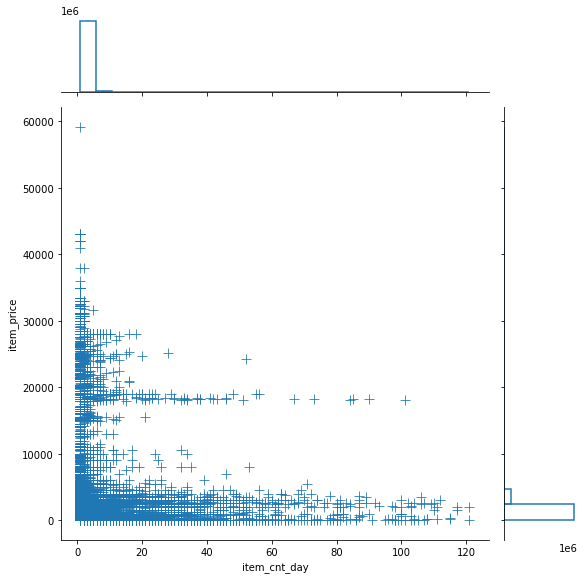

In [16]:
# check for outliers again
sns.jointplot(x="item_cnt_day", y="item_price", data=sales, height=8, 
              marker="+", s=100, marginal_kws=dict(bins=25, fill=False))

4. Feature engineering

In [17]:
# shops feature
shops = shops.copy()
shops['shop_name_len'] = shops['shop_name'].map(len).astype(np.uint32) #lenth of description
shops['shop_name_wordcount'] = shops['shop_name'].map(lambda x: len(str(x).split(' '))).astype(np.uint32) #word count of description
tfidf = text.TfidfVectorizer(max_features=10)
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(10):
    shops['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]].astype(np.float32)
    
shops = shops.drop(columns='shop_name')

In [18]:
shops.head()

,shop_id,shop_name_len,shop_name_wordcount,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9
0,0,29,4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
1,1,29,4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.445753,0.895156
2,2,16,3,0.0,0.866844,0.000000,0.0,0.0,0.0,0.0,0.0,0.498580,0.000000
3,3,30,3,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000
4,4,24,4,0.0,0.000000,0.905675,0.0,0.0,0.0,0.0,0.0,0.423972,0.000000


6. Prepare Data for Training

In [24]:
# collect sales for one month
sales_per_month = sales.groupby(["date_block_num","shop_id","item_id"])[
    "date_block_num","date","item_price","item_cnt_day"].agg(
    {"date_block_num":'mean',"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

sales_per_month = sales_per_month.item_cnt_day.apply(list).reset_index()
sales_per_month.head()

,date_block_num,shop_id,item_id,sum
0,0,2,33,1.0
1,0,2,482,1.0
2,0,2,491,1.0
3,0,2,839,1.0
4,0,2,1007,3.0


7. Mean encoding

In [33]:
def create_mean_encode_features_KFold(df, group_cols, agg_cols, agg_func, n_splits=6):
    """Create mean encoded features using K-Fold regularization
    
    Parameters
    ----------
    df : DataFrame
        DataFrame with monthly data
    group_cols : list of str
        List of column names which is used for group by
    agg_cols : list of str
        List of columns for aggregation using function specified in agg_func
    agg_func : str
        Function that will be applied for aggregation
    n_splits : int
        Number of K-Fold splits
        
    Returns
    -------
    df : DataFrame
        Updated DataFrame
    
    """
    kf = KFold(n_splits=n_splits)

    new_names = []
    for col in agg_cols:
        new_names.append('_'.join(group_cols).replace("_id","") + "_id_" + col + "_" + agg_func)
    
    for name in new_names:
        df[name] = np.nan

    for train, val in kf.split(df):
        X_train = df.iloc[train]
        X_val = df.iloc[val]
        group = X_train.groupby(group_cols, as_index=False)[agg_cols].agg(agg_func)
        tmp_names = list(range(len(agg_cols)))
        group.columns = group_cols + tmp_names
        X_val = pd.merge(X_val.reset_index(), group, on=group_cols, how='left').set_index("index")[tmp_names]
        df.loc[X_val.index, new_names] = X_val.values

    #fill missing values by means
    for col in new_names: 
        df[col].fillna(df[col].mean(), inplace=True)
    return df

In [35]:
monthly_sales = create_mean_encode_features_KFold(sales_per_month, ["item_id"], ['date_block_num', 'shop_id'], 'mean')

In [36]:
# combine two dfs for training
sales_dataset = pd.merge(test, sales_per_month, on=[
                         'item_id', 'shop_id'], how='left')

sales_dataset.fillna(0, inplace=True)

sales_dataset.drop(['shop_id', 'item_id'], inplace=True, axis=1)

sales_dataset.head()

,ID,date_block_num,sum,item_id_item_cnt_month_mean,item_id_item_price_mean_mean,item_id_item_id_mean,item_id_date_block_num_mean,item_id_shop_id_mean
0,0,20.0,1.0,0.0,0.0,0.0,27.528302,32.459119
1,0,22.0,1.0,0.0,0.0,0.0,27.528302,32.459119
2,0,23.0,2.0,0.0,0.0,0.0,27.310469,31.220217
3,0,24.0,2.0,0.0,0.0,0.0,27.310469,31.220217
4,0,28.0,1.0,0.0,0.0,0.0,25.583630,31.395018


In [37]:
# expand sales_dataset to a pivot table
sales_dataset_pivot = sales_dataset.pivot_table(
    index='ID', columns='date_block_num', fill_value=0, aggfunc='sum')
sales_dataset_pivot

item_id_date_block_num_mean                                     \
date_block_num                        0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0    
ID                                                                              
0                                 0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1                                 0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2                                 0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3                                 0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4                                 0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                    ...  ...  ...  ...  ...  ...  ...  ...   
214195                            0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
214196                            0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
214197                           20.767045  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
214198                            0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
214199                            0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                          ...  sum                                          \
date_block_num 8.0  9.0   ... 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0   
ID                        ...                                                
0               0.0  0.0  ...    2    0    0    0    1    1    1    3    1   
1               0.0  0.0  ...    0    0    0    0    0    0    0    0    0   
2               0.0  0.0  ...    0    0    0    0    3    2    0    1    3   
3               0.0  0.0  ...    0    0    0    0    0    0    0    1    0   
4               0.0  0.0  ...    0    0    0    0    0    0    0    0    0   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
214195          0.0  0.0  ...    2    1    1    0    0    0    0    0    0   
214196          0.0  0.0  ...    0    0    0    0    0    0    0    0    0   
214197          0.0  0.0  ...    1    1    0    0    0    0    0    0    0   
214198          0.0  0.0  ...    0    0    0    0    0    0    0    0    0   
214199          0.0  0.0  ...    0    0    0    0    0    0    0    0    0   

                     
date_block_num 33.0  
ID                   
0                 0  
1                 0  
2                 1  
3                 0  
4                 0  
...             ...  
214195            1  
214196            0  
214197            0  
214198            0  
214199            0  

[214200 rows x 204 columns]

In [38]:
# train-test split
X_train = np.expand_dims(
    sales_dataset_pivot.values[:, :-1], axis=2)  # without last column
y_train = sales_dataset_pivot.values[:, -1:]  # last column
X_train = shuffle(X_train, random_state=42)
y_train = shuffle(y_train, random_state=42)
X_test = np.expand_dims(sales_dataset_pivot.values[:, 1:], axis=2) # without first column

print(f'X-train shape:{X_train.shape}\n X-test shape:{X_test.shape}\n y-train shape:{y_train.shape}')

X-train shape:(214200, 203, 1)
 X-test shape:(214200, 203, 1)
 y-train shape:(214200, 1)


8. Model

In [39]:
# build a network
model = Sequential()
model.add(LSTM(16, input_shape=(33, 1),return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer="adam", loss='mse', metrics=["mse"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 33, 16)            1152      
_________________________________________________________________
dropout (Dropout)            (None, 33, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________


In [40]:
# fit
history = model.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
53/53 [==============================] - 118s 2s/step - loss: 4.4726 - mse: 4.4726
Epoch 2/10
53/53 [==============================] - 112s 2s/step - loss: 4.1501 - mse: 4.1501
Epoch 3/10
53/53 [==============================] - 112s 2s/step - loss: 5.4119 - mse: 5.4119
Epoch 4/10
53/53 [==============================] - 111s 2s/step - loss: 4.0183 - mse: 4.0183
Epoch 5/10
53/53 [==============================] - 111s 2s/step - loss: 6.0960 - mse: 6.0960
Epoch 6/10
53/53 [==============================] - 111s 2s/step - loss: 4.6705 - mse: 4.6705
Epoch 7/10
53/53 [==============================] - 110s 2s/step - loss: 6.8297 - mse: 6.8297
Epoch 8/10
53/53 [==============================] - 110s 2s/step - loss: 5.2516 - mse: 5.2516
Epoch 9/10
53/53 [==============================] - 110s 2s/step - loss: 5.2653 - mse: 5.2653
Epoch 10/10
53/53 [==============================] - 110s 2s/step - loss: 3.8062 - mse: 3.8062


<AxesSubplot:>

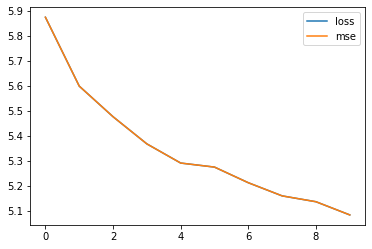

In [41]:
# plot learning curve
history_df = pd.DataFrame(history.history)
history_df.plot()

9. Submission

In [ ]:
submission_output = model.predict(X_test)
submission = pd.DataFrame({'ID':test['ID'], 'item_cnt_month':submission_output.ravel()})

# csv from dataframe
submission.to_csv('/kaggle/working/submission.csv', index = False)
submission.head()